<h3>Hough Line Transform</h3>

<h4>Cách biểu diễn một đường thẳng</h4>

Một đường thẳng có thể được biểu diễn dưới dạng phương trình tham số: <b>𝑦 = 𝑚𝑥 + 𝑐</b>. Tuy nhiên, việc sử dụng dạng này có vấn đề khi hệ số góc 𝑚 của đường thẳng tiếp cận vô cùng. Do đó, ta sử dụng một biểu diễn khác, dạng cực (polar form), để tránh các vấn đề này:<br> <b>𝜌 = 𝑥cos𝜃 + 𝑦sin𝜃</b><br>
Trong đó: 𝜌 là khoảng cách từ gốc tọa độ đến đường thẳng theo hướng vuông góc; 𝜃 là góc giữa đường vuông góc này và trục x.

Trong OpenCV, đường thẳng được biểu diễn bằng tham số cực (𝜌,𝜃), với: 
<ul>
    <li>𝜌: Khoảng cách từ gốc tọa độ (0,0) đến đường thẳng</li> 
    <li>𝜃: Góc của vector vuông góc với đường thẳng so với trục x, tính bằng radian.</li>
</ul>

OpenCV sử dụng các đơn vị:
    <ul>
        <li>𝜃 được tính bằng radian, với phạm vi từ 0 đến 𝜋 </li>
        <li>𝜌 là khoảng cách tính bằng pixel và có thể âm hoặc dương, điều này là do đường thẳng nằm ở các góc khác nhau trong không gian ảnh</li>
    </ul>
    

<h4>Phép biến đổi Hough Line</h4>

--> Không gian ảnh (image space): Là không gian mà mỗi điểm ảnh được xác định bởi tọa độ (x, y). <br>
--> Không gian tham số (parameter space): Là không gian mà mỗi đường thẳng được biểu diễn bằng một tập hợp các tham số.<br>

Biến đổi Hough chuyển đổi từ không gian ảnh sang không gian tham số bằng cách:
<ul>
    <li>Mỗi điểm trong không gian ảnh (x, y) sẽ tương ứng với một đường cong sin trong không gian tham số (𝜌,𝜃)</li>
    <li>Mỗi điểm trên đường cong này biểu diễn các giá trị (𝜌,𝜃) khả dĩ cho đường thẳng đi qua điểm (𝑥,𝑦)</li>
</ul>

Ví dụ dưới đây thể hiện một tập điểm (𝜌,𝜃) là đường cong sin chứa biểu diễn các đường thẳng đi qua điểm (x,y):

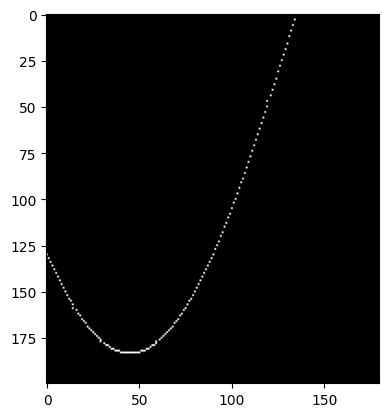

In [8]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Khởi tạo ảnh với kích thước 200x180, ban đầu tất cả các điểm ảnh đều màu đen: 𝜌 = 0->200; 𝜃 = 0->180
image = np.zeros((200, 180), dtype=np.uint8)

# Tọa độ của điểm (x, y)
x = 130
y = 130

# Xét các giá trị của theta từ 0 đến 180
thetas = np.deg2rad(np.arange(0, 180))

# Tính rho cho mỗi giá trị của theta
for theta in thetas:
    rho = int(x * np.cos(theta) + y * np.sin(theta))
    
    # Chỉ xét các giá trị của rho nằm trong khoảng 0 đến 199
    if 0 <= rho < 200:
        # Chuyển pixel (rho, theta) sang màu trắng
        image[rho, int(np.rad2deg(theta))] = 255

# Hiển thị ảnh kết quả
plt.imshow(image, cmap='gray')
plt.show()


<h4>Accumulator (bộ tích lũy)</h4>

<ul>
    <li>Một mảng tích lũy (accumulator array) được sử dụng để ghi lại các lần bỏ phiếu (votes) của các cặp giá trị (𝜌,𝜃).</li>
    <li>Các điểm ảnh trong hình ảnh sẽ tăng giá trị tại các vị trí tương ứng trong mảng tích lũy.</li>
    <li>Sau khi tất cả các điểm ảnh trong hình đã được xử lý, các ô trong mảng tích lũy có giá trị cao sẽ biểu thị các tham số của các đường thẳng có nhiều điểm ảnh nằm trên đó.</li>
</ul>

<h4>Phát hiện đường thẳng</h4>

Các cặp giá trị (𝜌,𝜃) với số lượng phiếu cao nhất trong mảng tích lũy sẽ tương ứng với các đường thẳng được phát hiện trong không gian ảnh. 

Từ cặp giá trị này, ta suy ngược lại tìm đường thẳng trong hình ảnh theo công thức chuyển đổi từ không gian tham số sang không gian ảnh như sau:
<ul>
    <li>Tọa độ điểm trung tâm trên đường thẳng được tính bằng: <b>𝑥0 = 𝜌⋅cos⁡(𝜃)​ và 𝑦0 = 𝜌⋅sin⁡(𝜃)</b></li>
    <li>Tọa độ các điểm khác tính theo công thức: <b>x1​ = x0​ + m⋅(−sin(θ)) và 𝑦1 = 𝑦0 + m⋅cos⁡(𝜃)</b> với m là 1 số tùy ý </li>
</ul>

<h4>Hough Transform trong OpenCV</h4>

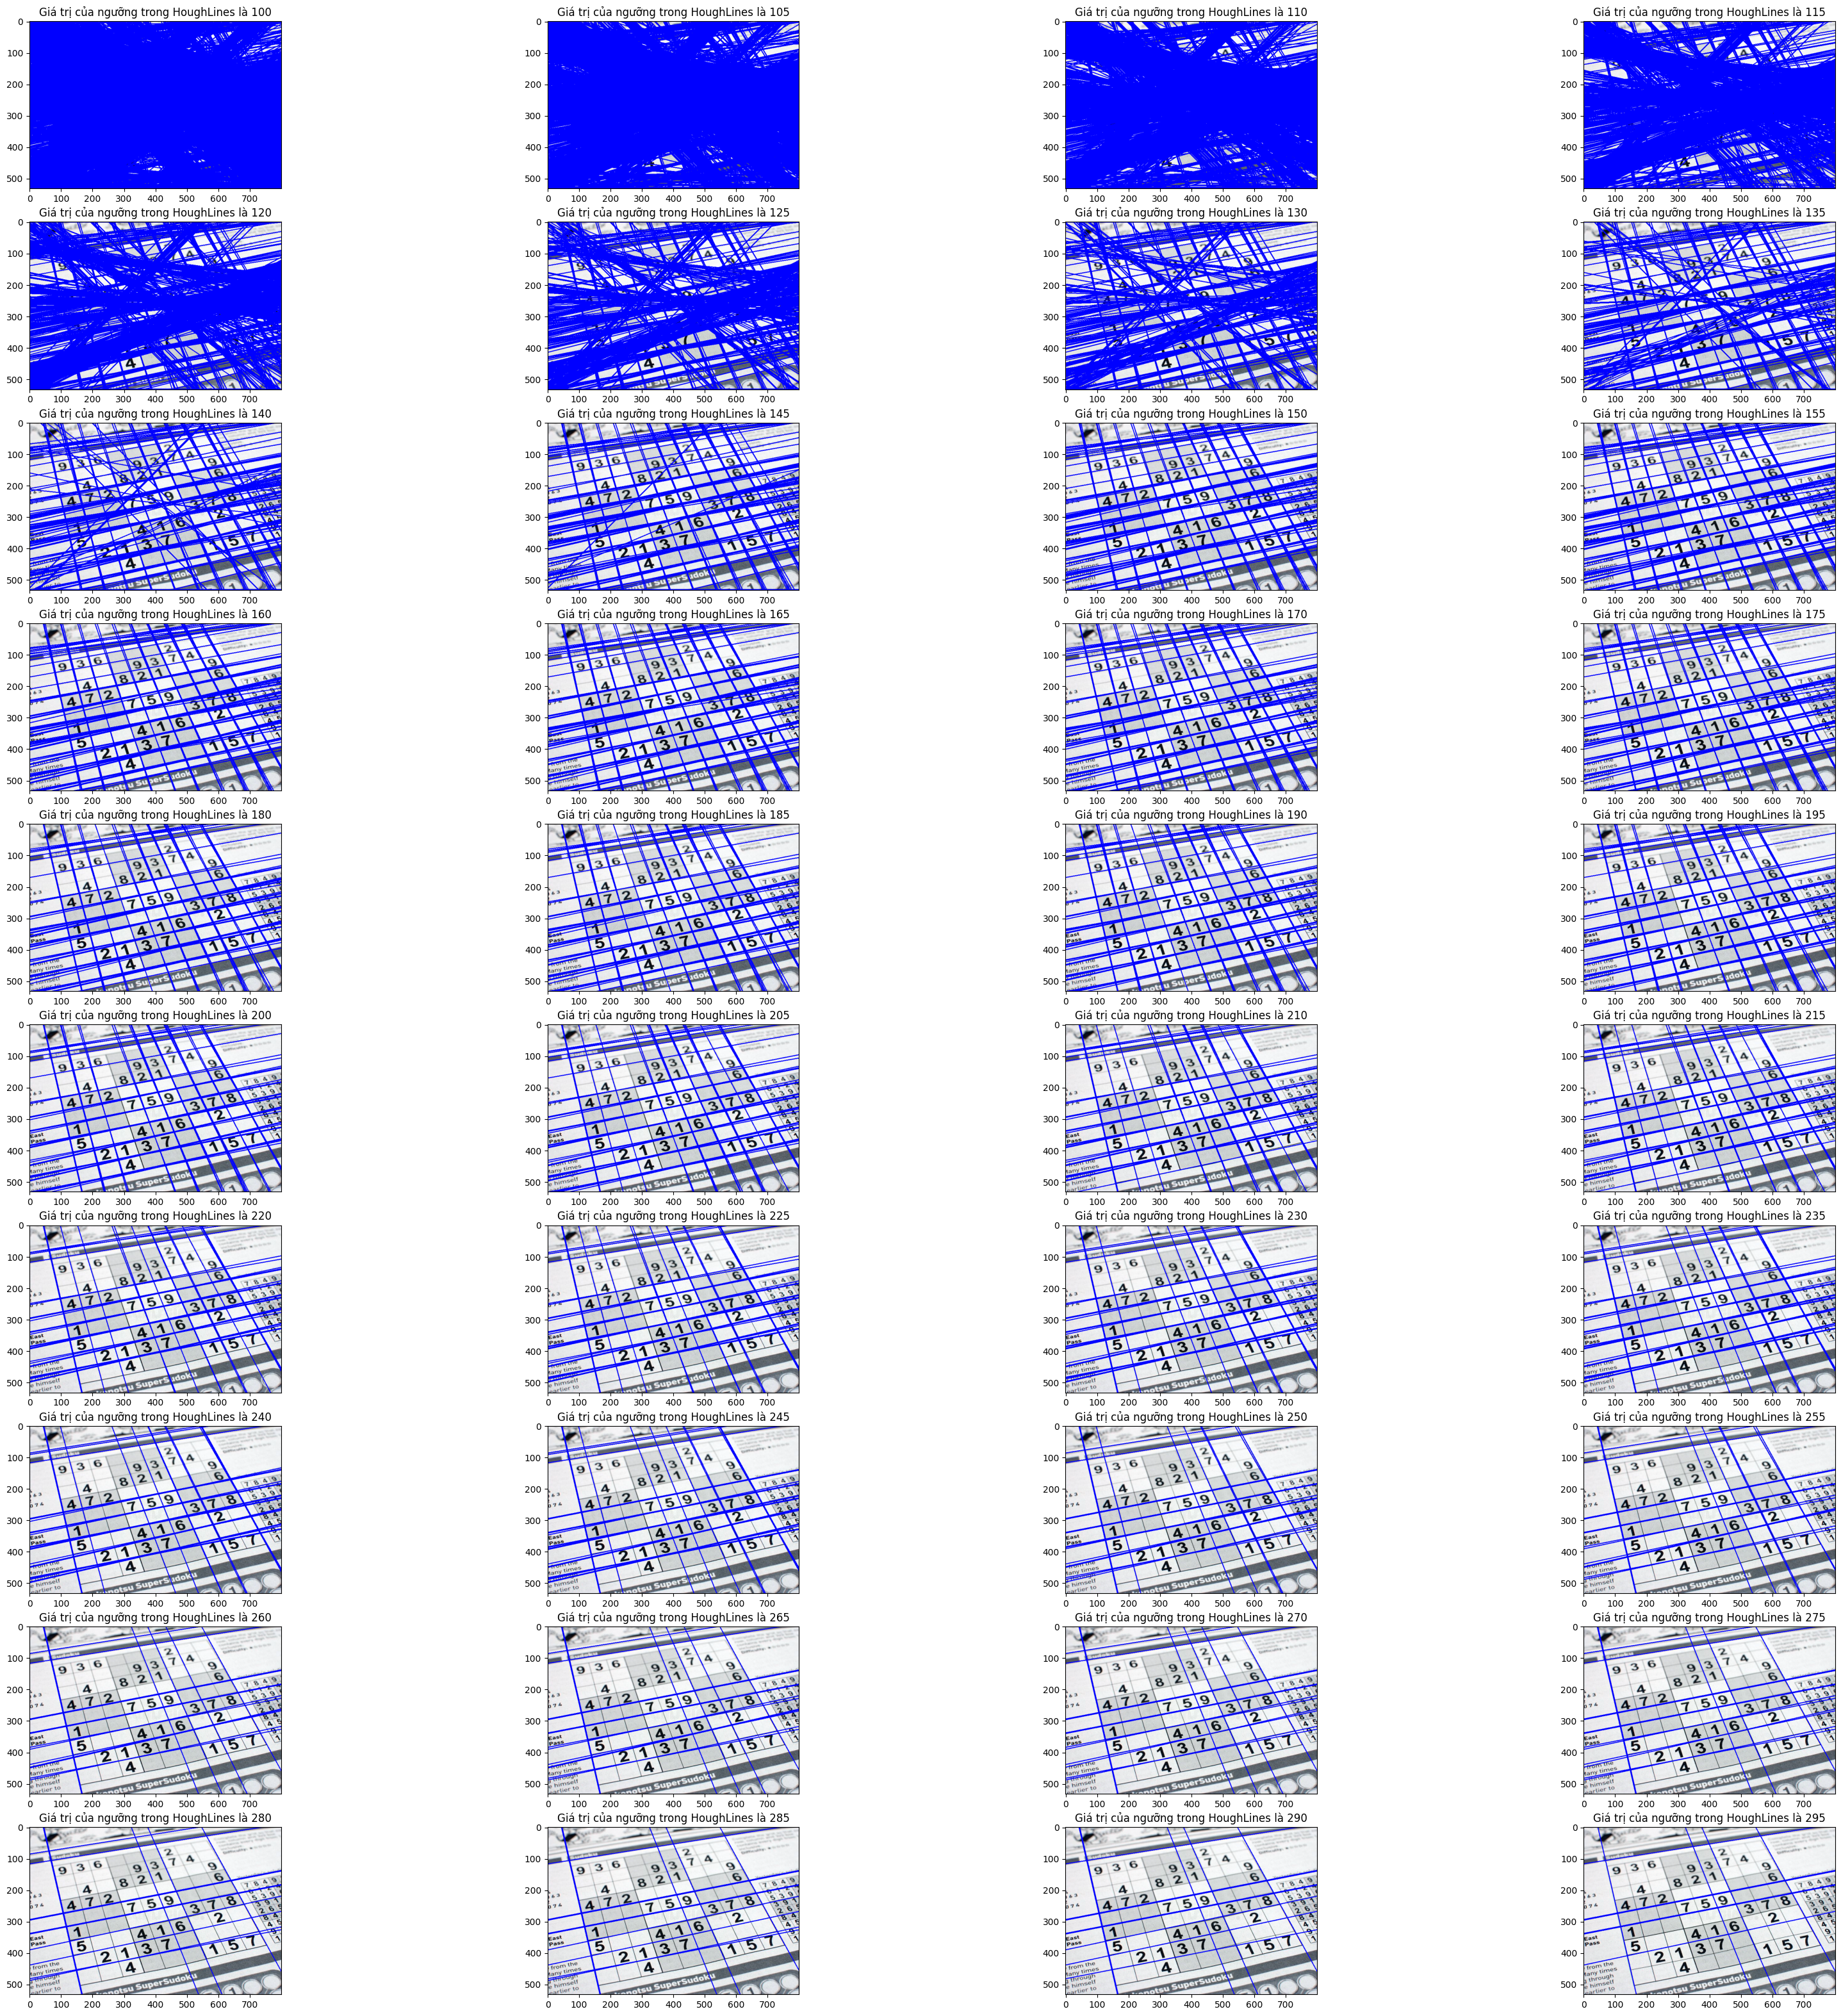

In [102]:
# lines = cv2.HoughLines(image, rho, theta, threshold, ........)
# --> image: Ảnh đầu vào. Đây là một ảnh nhị phân (thường là ảnh kết quả từ bộ lọc Canny) mà trong đó các pixel khác 0 biểu thị các cạnh.
# --> rho: Độ phân giải trong khoảng cách của tham số 𝜌 trong không gian Hough. Đơn vị của nó thường là pixel. Nếu 𝜌=1 thì độ phân giải sẽ là 1 pixel.
# --> theta: Độ phân giải trong góc của tham số 𝜃 trong không gian Hough. Đơn vị của nó là radian. Nếu 𝜃=𝑛𝑝.𝑝𝑖/180 thì độ phân giải sẽ là 1 độ.
# --> threshold: Ngưỡng bỏ phiếu. Chỉ các đường thẳng có số lượng bỏ phiếu vượt quá ngưỡng này mới được coi là đường thẳng hợp lệ.

# --> lines: Đầu ra của hàm. Đây là một mảng chứa các cặp giá trị (𝜌,𝜃).

import cv2
import numpy as np

img = cv2.imread('hough_line.jpg')
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
edges = cv2.Canny(gray, 50, 150, apertureSize = 3)

plt.figure(figsize = [40, 40])
j = 0
for i in range(100, 300, 5):
    j = j + 1
    lines = cv2.HoughLines(edges, 1, np.pi/180, i)
    img_copy = img.copy()
    if lines is not None:
        for line in lines:
            rho, theta = line[0]
            a = np.cos(theta)
            b = np.sin(theta)
            x0 = a*rho
            y0 = b*rho
            x1 = int(x0 + 1000*(-b))
            y1 = int(y0 + 1000*(a))
            x2 = int(x0 - 1000*(-b))
            y2 = int(y0 - 1000*(a))
        
            cv2.line(img_copy, (x1,y1), (x2,y2), (0,0,255), 2)
            
    plt.subplot(10, 4, j)
    plt.imshow(img_copy)
    plt.title("Giá trị của ngưỡng trong HoughLines là {}".format(i))

<h3>Probabilistic Hough Transform</h3>

Trong phép biến đổi Hough, chúng ta phải xét qua tất cả điểm ảnh trong ảnh, khối lượng tính toán rất nhiều. Biến đổi Hough xác suất là sự tối ưu hóa của Biến đổi Hough. Nó không xem xét tất cả các điểm, thay vào đó chỉ lấy một tập hợp con các điểm ngẫu nhiên và điều đó là đủ để phát hiện dòng. Chỉ cần chúng ta phải giảm ngưỡng. Hình ảnh bên dưới so sánh Biến đổi Hough và Biến đổi Hough xác suất trong không gian Hough. <br>

<img style="margin-left: 300px" src="https://opencv24-python-tutorials.readthedocs.io/en/latest/_images/houghlines4.png">

--> <b>cv2.HoughLinesP(edges, 1, np.pi/180, 100, minLineLength, maxLineGap) </b> <br>
Trong đó:
<ul>
    <li>
        minLineLength - Độ dài tối thiểu của dòng. Các đoạn đường ngắn hơn mức này sẽ bị từ chối.
    </li>
   <li>
        maxLineGap - Khoảng cách tối đa được phép giữa các đoạn dòng để coi chúng là một dòng.
    </li> 
</ul>

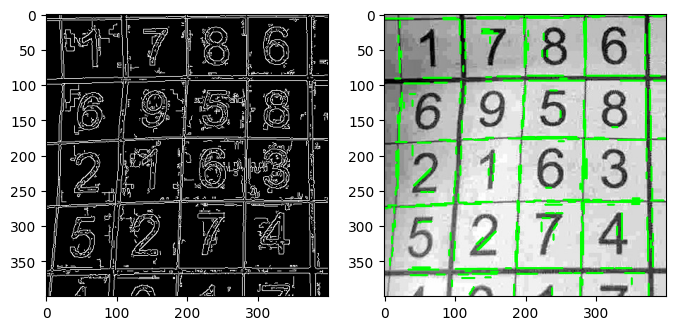

In [101]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

img_original = cv2.imread('hough_line_P.jpg')
img = img_original[300:700, 200:600]
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
edges = cv2.Canny(gray, 50, 150, apertureSize = 3)

minLineLength = 200
maxLineGap = 8
lines = cv2.HoughLinesP(edges, 1, np.pi/180, 50, minLineLength, maxLineGap)

img_copy = img.copy()
if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            cv2.line(img_copy, (x1,y1), (x2,y2), (0,255,0), 2)

plt.figure(figsize = [8,4])
plt.subplot(121); plt.imshow(edges, cmap="gray")
plt.subplot(122); plt.imshow(img_copy)

<h3>Hough Circle Transform</h3>

Một vòng tròn được biểu diễn bằng toán học như (x - x_center)^2 + (y - y_center)^2 = r^2, với (x_center, y_center)là tâm của vòng tròn và r là bán kính của vòng tròn. Từ phương trình, chúng ta có thể thấy chúng ta có 3 tham số, vì vậy chúng ta cần một bộ tích lũy 3D để biến đổi Hough, điều này sẽ rất kém hiệu quả. Vì vậy, OpenCV sử dụng phương pháp phức tạp hơn, Phương pháp Hough Gradient sử dụng thông tin độ dốc của các cạnh.

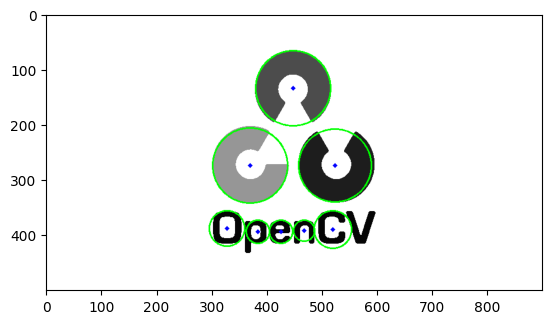

In [103]:
# circles = cv2.HoughCircles(image, method, dp, minDist, param1, param2, minRadius, maxRadius)
# --> image: Hình ảnh đầu vào, hình ảnh phải là ảnh xám (grayscale) và đã được làm sạch nền (nếu cần).
# --> method: Phương pháp sử dụng để phát hiện hình tròn. Trong OpenCV, có một phương pháp được hỗ trợ, đó là cv2.HOUGH_GRADIENT.
# --> dp: Tỉ lệ giảm trên không gian Hough. Giá trị này xác định độ phân giải của không gian Hough so với không gian ảnh. Thông thường, nó được đặt là 1
# --> minDist: Khoảng cách tối thiểu giữa các vị trí trung tâm ước lượng được (tính theo pixel).
# --> param1: Tham số cố định giới hạn trên hoặc thấp hơn cho việc phát hiện các cạnh. Giá trị này phụ thuộc vào chất lượng của hình ảnh đầu vào.
# --> param2: Tham số ngưỡng cho việc phát hiện hình tròn. Nó là ngưỡng cho sự trùng khớp của vị trí trung tâm ước lượng được.
# --> minRadius: Độ lớn nhỏ nhất của hình tròn được phát hiện (tính theo pixel). Bằng 0 tức là không có giới hạn
# --> maxRadius: Độ lớn lớn nhất của hình tròn được phát hiện (tính theo pixel). Bằng 0 tức là không có giới hạn

# --> circles: Một mảng numpy chứa các thông tin về các hình tròn được phát hiện. 
#              Mỗi hàng trong mảng này chứa ba giá trị, là tọa độ (x, y) của trung tâm hình tròn và bán kính của hình tròn.

import cv2
import numpy as np
import matplotlib.pyplot as plt

img = cv2.imread('hough_circle.png',0)
img = cv2.medianBlur(img, 5)
cimg = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

circles = cv2.HoughCircles(img, cv2.HOUGH_GRADIENT, 1, 20, param1 = 50, param2 = 30, minRadius = 0, maxRadius = 0)

circles = np.uint16(np.around(circles))
for i in circles[0,:]:
    # draw the outer circle
    cv2.circle(cimg, (i[0],i[1]), i[2], (0,255,0), 2)
    # draw the center of the circle
    cv2.circle(cimg, (i[0],i[1]), 2, (0,0,255), 3)

plt.imshow(cimg)